Describe invertible calculus.
first examples $(f(x), [b_{1}, b_{1}, ...])$ give concrete examples
then given $f(x) \in \mathcal{O}(\mathbb{C})$ then $f(x)$ is defined by a taylor series $[a_0, a_1, a_2, ...]$
so $(f(x), [b_{1}, b_{2}, ...]) = ([a_1, a_2, a_3, ...], [b_1, b_2, ...]) = ([..., a_{-2}, a_{-1}, a_0, a_1, a_2, ...])$ where $b_n = a_{-n}$

In [1]:
import Graphics.Rendering.Chart.Easy
import Graphics.Rendering.Chart.Backend.Cairo

In [2]:
type Function = (Double -> Double)

_AnalyticAccuracy = 100

class Differentiable a where
    derivative :: a -> a
    antiderivative :: a -> a

class Analytic a where
    toFunction :: a -> Function

repeat' = concat . repeat

linspace :: Double -> Double -> Int -> [Double]
linspace start stop num =
    let dx = (stop - start)/fromIntegral (num - 1)
    in [fromIntegral i*dx + start| i <- [0 .. (num - 1)]]

factorial :: Integer -> Integer
factorial 0 = 1
factorial n = n*factorial (n - 1)

In [3]:
data TaylorSeries = Constant Double | TaylorSeries [Double]

instance Show TaylorSeries where
    show (TaylorSeries terms) = "Taylor Series: " ++ init (show (take 10 terms)) ++ " ... ]"
    show (Constant a) = "Constant: " ++ show a

instance Num TaylorSeries where
    (+) (Constant a) (Constant b) = Constant (a + b)
    (+) (Constant a) (TaylorSeries (b:terms)) = TaylorSeries (a+b:terms)
    (+) function (Constant a) = Constant a + function 
    (+) (TaylorSeries termsA) (TaylorSeries termsB) = TaylorSeries [a+b | (a, b) <- zip (termsA ++ repeat 0) (termsB ++ repeat 0)]
    
    negate (Constant a) = Constant $ negate a
    negate (TaylorSeries terms) = TaylorSeries $ map negate terms
    
    abs (Constant a) = Constant $ abs a
    abs (TaylorSeries terms) = TaylorSeries $ map abs terms
    
    fromInteger a = Constant $ fromInteger a
    
    (*) (Constant a) (Constant b) = Constant (a*b)
    (*) (Constant a) (TaylorSeries terms) = TaylorSeries $ map (a*) terms
    (*) function (Constant a) = Constant a * function 
    (*) _ _ = error "Undefined"
    signum _ = error "Undefined"

instance Fractional TaylorSeries where
    fromRational a = Constant $ fromRational a
    
    (/) (Constant a) (Constant b) = Constant (a/b)
    (/) (TaylorSeries terms) (Constant a) = TaylorSeries $ map (*recip a) terms
    (/) _ _ = error "Undefined"

instance Analytic TaylorSeries where
    toFunction (TaylorSeries taylorSeries) =
        let function :: TaylorSeries -> Function
            function (TaylorSeries taylorSeries) x = sum [a*x^^n/fromIntegral (factorial n) | (a, n) <- zip taylorSeries [0..] ]
        in function $ TaylorSeries (take _AnalyticAccuracy taylorSeries)

instance Differentiable TaylorSeries where
    derivative (TaylorSeries (a:function)) = TaylorSeries function

    antiderivative (TaylorSeries function) = TaylorSeries (0:function)

In [4]:
data ShiftFunction = Scalar Double | ShiftFunction [Double] [Double]

instance Show ShiftFunction where
    show (ShiftFunction (a_0:terms) intterms) = "Shift function: [... " ++ (init.tail.show.reverse.take 4) intterms ++ ",(" ++ show a_0 ++ ")," ++ (init.tail.show.take 4) terms ++ " ...]"
    show (Scalar a) = "Constant: " ++ show a

instance Num ShiftFunction where
    (+) (Scalar a) (Scalar b) = Scalar (a + b)
    (+) (Scalar a) (ShiftFunction (b:terms) intterms) = ShiftFunction (a+b:terms) intterms
    (+) function (Scalar a) = Scalar a + function 
    (+) (ShiftFunction termsA inttermsA) (ShiftFunction termsB inttermsB) = ShiftFunction [a+b | (a, b) <- zip (termsA ++ repeat 0) (termsB ++ repeat 0)] [a+b | (a, b) <- zip (inttermsA ++ repeat 0) (inttermsB ++ repeat 0)]
    
    negate (Scalar a) = Scalar $ negate a
    negate (ShiftFunction terms intterms) = ShiftFunction (map negate terms) (map negate intterms)
    
    abs (Scalar a) = Scalar $ abs a
    abs (ShiftFunction terms intterms) = ShiftFunction (map abs terms) (map abs intterms)
    
    fromInteger a = Scalar $ fromInteger a
    
    (*) (Scalar a) (Scalar b) = Scalar (a*b)
    (*) (Scalar a) (ShiftFunction terms intterms) = ShiftFunction (map (a*) terms) (map (a*) intterms)
    (*) function (Scalar a) = Scalar a * function 
    (*) _ _ = error "Undefined"
    signum _ = error "Undefined"

instance Fractional ShiftFunction where
    fromRational a = Scalar $ fromRational a
    
    (/) (Scalar a) (Scalar b) = Scalar (a/b)
    (/) (ShiftFunction terms intterms) (Scalar a) = ShiftFunction (map (*recip a) terms) (map (*recip a) intterms)
    (/) _ _ = error "Undefined"

instance Analytic ShiftFunction where
    toFunction (ShiftFunction terms intterms) =
        let function :: ShiftFunction -> Function
            function (ShiftFunction terms _) x = sum [a*x^^n/fromIntegral (factorial n) | (a, n) <- zip terms [0..] ]
        in function $ ShiftFunction (take _AnalyticAccuracy terms) []

instance Differentiable ShiftFunction where
    derivative (ShiftFunction (a:terms) intterms) = ShiftFunction terms (a:intterms)

    antiderivative (ShiftFunction terms (a:intterms)) = ShiftFunction (a:terms) intterms

In [5]:
data StackFunction = StackFunction ShiftFunction String

instance Show StackFunction where
    show (StackFunction (Scalar a) _) = show (Scalar a)
    show (StackFunction (ShiftFunction _ intterms) function) = "StackFunction: (" ++ function ++ ",[" ++ (init.tail.show.take 10) intterms ++ "...])"

instance Num StackFunction where
    (+) (StackFunction functionA labelA) (StackFunction functionB labelB) = StackFunction (functionA + functionB) (labelA ++ "+" ++ labelB)
    
    negate (StackFunction function label) = StackFunction (-function) ("-" ++ label)
    
    abs (StackFunction function label) = StackFunction (abs function) ("abs(" ++ label ++ ")")
    
    fromInteger a = StackFunction (fromInteger a) (show a)
    
    (*) (StackFunction functionA labelA) (StackFunction functionB labelB) = StackFunction (functionA*functionB) (labelA ++ "*" ++ labelB)
    signum _ = error "Undefined"

instance Analytic StackFunction where
    toFunction (StackFunction function _) = toFunction function

instance Differentiable StackFunction where
    derivative (StackFunction function label) = StackFunction (derivative function) ("(d/dx)" ++ label)

    antiderivative (StackFunction function label) = StackFunction (antiderivative function) ("(d/dx)^(-1)" ++ label)

In [24]:
eval :: (Analytic a) => a -> [Double] -> [(Double, Double)]
eval function xs = [(x, toFunction function x) | x<-xs]
plot' x function = toRenderable (plot (line "func" [eval function x]))
plots x functions = toRenderable (plot (line "func" [eval function x | function <- functions]))

shift :: Double -> ShiftFunction -> ShiftFunction
shift h (ShiftFunction terms intterms) = ShiftFunction newterms newintterms where
    newterms = [toFunction (ShiftFunction (drop n terms) []) h | n <- [0 ..]]
    newintterms = [toFunction (ShiftFunction (reverse (take n intterms) ++ terms) []) h | n <- [1 ..]]

exp' = TaylorSeries $ repeat 1
sin' = TaylorSeries $ repeat' [0, 1, 0, -1]
cos' = TaylorSeries $ repeat' [1, 0, -1, 0]

exp'' = ShiftFunction (repeat 1) (repeat 1)
sin'' = ShiftFunction (repeat' [0, 1, 0, -1]) (repeat' [-1, 0, 1, 0])
cos'' = ShiftFunction (repeat' [1, 0, -1, 0]) (repeat' [0, -1, 0, 1])

exp''' = StackFunction exp'' "exp(x)"
cos''' = StackFunction cos'' "cos(x)"
sin''' = StackFunction sin'' "sin(x)"

Shift function: [... 8.0,2.0,-4.0,2.0,(1.7168146928204138),2.0,-4.0,2.0,8.0 ...]

Shift function: [... 2.000000165480742,-4.000000330961484,2.000000165480742,1.716804476359357,(2.000000165480742),-4.000000330961484,2.000000165480742,8.000000661922968,2.000000165480742 ...]

Shift function: [... -1.6548074199818075e-7,3.309614839963615e-7,-1.6548074199818075e-7,1.0216461056700155e-5,(-1.6548074199818075e-7),3.309614839963615e-7,-1.6548074199818075e-7,-6.61922967992723e-7,-1.6548074199818075e-7 ...]

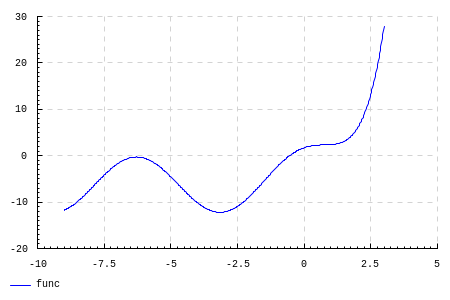

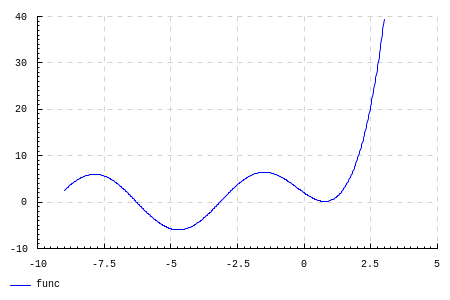

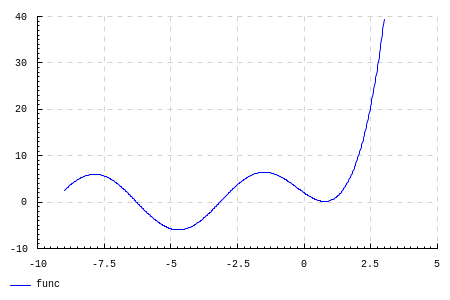

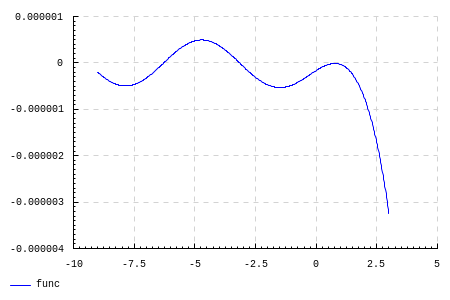

In [26]:
x = linspace (-9) 3 500

func' = 6*cos' + 2*exp' - 2*Constant pi
func'' = 6*cos'' + 2*exp'' - 2*Scalar pi
func''' = 6*cos''' + 2*exp''' - 2*StackFunction (Scalar pi) "pi"
func = func''
h = 0.00000000001
test = (shift h func - func)/h
print func
print test
print (derivative func - test)
plot' x func
plot' x test
plot' x $ derivative func
plot' x (derivative func - test)
--plot' x $ antiderivative func

In [ ]:
f = ShiftFunction (repeat 1) (repeat 1)
(derivative.derivative) f - 2*derivative f + 3*f

differential function $f'' - 2*f' + 3*f = 0$, try $f = e^{ax}$, then $a^2f - 2*a*f + 3*f = 0$ quadradic equation for ansatz $a^2 - 2*a + 3 = 0$ solution to ansatz $a = \frac{2+\sqrt{4-4*3}}{2}$ so $f(x) = 2e^x cos(x\sqrt{2})$

Recursive equation $a_{n+2} - 2*a_{n+1} + 3*a_n = 0$ rearanging then $a_n = \frac{2*a_{n+1} - a_{n+2}}{3}$, and $a_{n+2} = 2*a_{n+1} - 3*a_n$

In [ ]:
--terms :: (Num a) => a -> a -> Int -> a
--terms a b 0 = a
--terms a b 1 = b
--terms a b n = 2*terms a b (n - 1) - 3*terms a b (n-2)

--intterms :: (Fractional a) => a -> a -> Int -> a
--intterms a b 0 = a
--intterms a b 1 = b
--intterms a b n = (2*intterms a b (n + 1) - intterms a b (n + 2))/3

terms :: (Num a) => a -> a -> [a]
terms a b = let list = a:b:zipWith (\x y->2*y-3*x) list (tail list)
            in list

intterms :: (Fractional a) => a -> a -> [a]
intterms a b = let list = b:a:zipWith (\y x->(2*y - x)/3.0) (tail list) list
                in drop 2 list

(a, b) = (0, -10)

g = TaylorSeries $ terms a b
g' = ShiftFunction (terms a b) (intterms a b)

In [ ]:
x = linspace (-3) 3 100

print g'
print $ derivative g'
print $ antiderivative g'

plot' x g'
plot' x $ derivative g'
plot' x $ antiderivative g'

In [ ]:
gs = [TaylorSeries $ terms (-1) a | a <- linspace (-2) 2 10]
plots x gs
gs = [TaylorSeries $ terms a 0 | a <- linspace (-2) 0 10]
plots x gs
gs = [TaylorSeries $ terms a b | a <- linspace (-2) 2 10, b <- linspace (-2) 0 10]
plots x gs

In [1]:
data Derivative = D | Dn Derivative deriving Eq
data Dx a = C a | Dx a Derivative deriving Eq

count :: Derivative -> Integer
count D = 1
count (Dn d) = 1 + count d

instance Show Derivative where
    show D = "dx"
    show d = "dx^" ++ show (count d)

instance (Show a, Num a, Eq a) => Show (Dx a) where
    show (C a) = show a
    show (Dx a d)
        | a == 1 = show d
        | a == 0 = show a
        | otherwise = show a ++ show d

instance Semigroup Derivative where
    (<>) D D = Dn D
    (<>) D (Dn dn) = Dn (Dn dn)
    (<>) d D = D <> d
    (<>) (Dn dn) d = dn <> Dn d

instance (Num a) => Semigroup (Dx a) where
    (<>) (C a) (C b) = C (a*b)
    (<>) (C a) (Dx b d) = Dx (a*b) d
    (<>) d (C a) = C a <> d
    (<>) (Dx a dn) (Dx b dm) = Dx (a*b) (dn<>dm)

instance (Num a) => Monoid (Dx a) where
    mempty = C 1

d = Dx 1.2 D
mappend d d

1.44dx^2

In [1]:
import Graphics.Rendering.Chart.Easy
import Graphics.Rendering.Chart.Backend.Cairo

linspace :: Double -> Double -> Int -> [Double]
linspace start stop num =
    let dx = (stop - start)/fromIntegral (num - 1)
    in [fromIntegral i*dx + start| i <- [0 .. (num - 1)]]

repeat' = concat . repeat

factorial 0 = 1
factorial n = n*factorial (n - 1)
toFunction taylorSeries x = sum [a*x^^n/fromIntegral (factorial n) | (a, n) <- zip (take 50 taylorSeries) [0..] ]

--eval :: (Analytic a) => a -> [Double] -> [(Double, Double)]
eval taylorSeries xs = [(x, toFunction taylorSeries x) | x<-xs]

binding :: (Monad m) => [m a] -> m a
binding [a] = a
binding (a:as) = a >> binding as

plotTaylorSeries functions x = toRenderable $ binding [plot (line name [eval function x]) | (function, name) <- functions]

In [27]:
type Coefficient = Double
type TaylorSeries = [Coefficient]
-- TaylorSeries is a list of coefficients (type Double)

derivative :: TaylorSeries -> TaylorSeries
derivative (a_0:a_k) = a_k
-- derivative [a_0, a_1, a_2 ... ] = [a_1, a_2, a_3 ... ]

antiderivative :: Coefficient -> TaylorSeries -> TaylorSeries
antiderivative integrationConstant taylorSeries = integrationConstant:taylorSeries
-- antiderivative [a_1, a_2, a_3 ... ] a = [a, a_1, a_2 ... ]

printTaylorSeries taylorSeries = "Taylor Series: " ++ (init . show . take 10) taylorSeries ++ " ... ]"

"Taylor Series: [1.0,0.0,-1.0,0.0,1.0,0.0,-1.0,0.0,1.0,0.0 ... ]"

"Taylor Series: [0.0,-1.0,0.0,1.0,0.0,-1.0,0.0,1.0,0.0,-1.0 ... ]"

"Taylor Series: [1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0 ... ]"

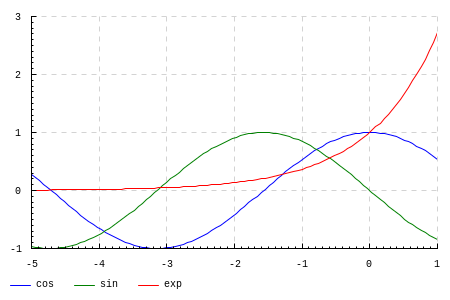

In [54]:
x = linspace (-5) 1 100
-- x =: [-10, 2] resolved at 200 points

-- Define simple functions by the coeffiecients of their taylor series
cos = repeat' [1, 0, -1, 0] :: TaylorSeries
sin = derivative cos
exp = repeat 1 :: TaylorSeries

-- Print and Plot
printTaylorSeries cos
printTaylorSeries sin
printTaylorSeries exp

plotTaylorSeries [(cos, "cos"), (sin, "sin"), (exp, "exp")] x

"Taylor Series: [1.0,0.0,-1.0,0.0,1.0,0.0,-1.0,0.0,1.0,0.0 ... ]"

"Taylor Series: [2.0,0.0,-1.0,0.0,1.0,0.0,-1.0,0.0,1.0,0.0 ... ]"

"Taylor Series: [1.0,0.0,-1.0,0.0,1.0,0.0,-1.0,0.0,1.0,0.0 ... ]"

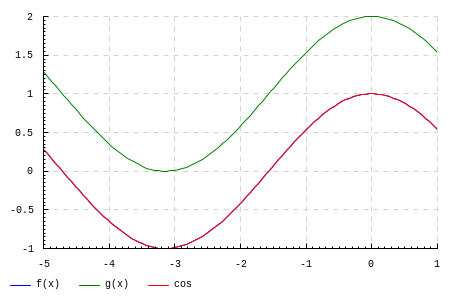

In [55]:
a = derivative (antiderivative 2 cos)
b = antiderivative 2 (derivative cos)

printTaylorSeries a
printTaylorSeries b
printTaylorSeries cos
plotTaylorSeries [(a, "f(x)"), (b, "g(x)"), (cos, "cos")] x

note that $f(x) \neq g(x)$ but $f(x) = \cos(x)$